## Importação das bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import pyart


import warnings
import math
from mpl_toolkits.basemap import Basemap

warnings.filterwarnings('ignore')
%matplotlib inline

### Leitura dos dados

In [3]:
xds = xr.open_dataset('data/sbmn_cappi_20140103_031208.nc')

### Descrição das variáveis

In [4]:
xds.data_vars

Data variables:
    start_time      (time) datetime64[ns] ...
    stop_time       (time) datetime64[ns] ...
    time_bounds     (time, bounds) datetime64[ns] ...
    grid_mapping_0  int32 ...
    VEL             (time, z0, y0, x0) float32 ...
    DBZc            (time, z0, y0, x0) float32 ...
    range           (time, z0, y0, x0) float32 ...
    Coverage        (time, z0, y0, x0) float32 ...

#### Unidade das variáveis

In [5]:
dbz_unit = xds.DBZc.units
x0_unit = xds.x0.units
y0_unit = xds.y0.units

print('Unidade DBCc:   '+dbz_unit+ '\nUnidade de X0:  ' + x0_unit + '\nUnidade de Y0:  ' + y0_unit)

Unidade DBCc:   dBZ
Unidade de X0:  km
Unidade de Y0:  km


#### Agregação dos valores

In [6]:
dbz = xds.DBZc.data
lat = xds.DBZc['lat0'].data
lon = xds.DBZc['lon0'].data
x0 = xds.DBZc['x0'].data
y0 = xds.DBZc['y0'].data
rrange = xds.range.data
rrange = rrange[0]

### Calculo do MAXCAPPI

In [7]:
def mCAP(data):
    mc = np.fmax(dbz[0][0],dbz[0][1]) 
    for i in range(2,len(data)):
        mc = np.fmax(mc,dbz[0][i])
    return mc

In [8]:
def radarRange(rrange):
    
    vrange = np.zeros(241*241)-9999
    vrange = np.reshape(vrange,(241,241)) 
    
    km = np.amax(rrange, where=~np.isnan(rrange), initial=-1)
    
    print('Max Range: ' + str(km-2))
  
    for i in range(len(rrange)):
        for j in range(len(rrange)):
            if (rrange[i][j]) < km-1:
                vrange[i][j] = np.float32('nan')
            else:
                vrange[i][j] = rrange[i][j]
                
    ## Preenche com max value
    for i in range(len(rrange)):
        for j in range(len(rrange)):
            if vrange[i][j] == -9999:
                vrange[i][j] = np.float32('nan')
    return vrange

In [ ]:
def VIL(data):
    vil = 0
    Z = data[0]
   # print (Z)
    for i in range(len(Z-1)):
        #vil = 3.44*10**(-6)*(((Z[i] + Z[i+1])/2)**(4/7))*0.5
        print("Nível: " + str([i]) + " " + str(Z[i+1]) + "")
    
    return vil

In [15]:
maxrange = radarRange(rrange[39])

Max Range: 237.5


In [12]:
dados = mCAP(dbz[0])

### Plot MAXCAPPI

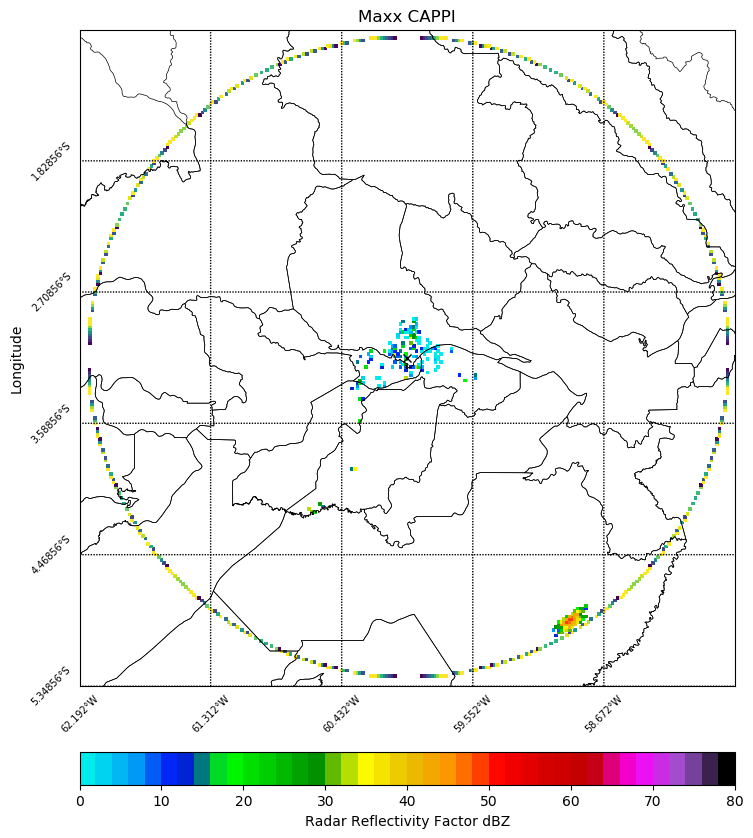

In [16]:
my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
zoom_scale = 2.2                        ## ZOOM SCALE


bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
        my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
label = 'Radar Reflectivity Factor ' + dbz_unit+ ''
title = 'Maxx CAPPI'

levs = np.linspace(0,80,41,endpoint=True)
norm = mpl.colors.BoundaryNorm(levs,256)
cmap = 'pyart_NWSRef'
ax = axes

m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

xi, yi = m(lon, lat)
xm, ym = m(my_coords[1],my_coords[0])


m.pcolormesh(xi,yi,maxrange)

cs = m.pcolormesh(xi,yi,dados,norm=norm,cmap=cmap,ax=ax)
m.plot(xm,ym, marker='x',color='k')


# # # # Add Grid Lines
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
#m.drawmapboundary(fill_color='green')

m.readshapefile('./data/am_municipios/13MUE250GC_SIR', 'teste')

# # # # # Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(label)

# # # # # Add Title
plt.title(title)
plt.ylabel('Longitude', labelpad=40)
plt.xlabel('Latitude', labelpad=60)

plt.show()